In [1]:
library(tidyverse)
library(io)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: filenamer



## Helper Functions

In [2]:
# plot_auc_bar <- function(data, x_col, y_col, fill_col, 
# 												 x_label = "Dataset", y_label = "AUROC", title = NULL,
# 												 base_size = 20, legend_row = 3) {
	
# 	# Ensure the column names provided exist in the dataframe
# 	if (!all(c(x_col, y_col, fill_col) %in% names(data))) {
# 		stop("One or more specified column names do not exist in the dataframe.")
# 	}
	
# 	# Create the plot
# 	p <- ggplot(data, aes(x = .data[[x_col]], 
# 												y = .data[[y_col]], 
# 												fill = .data[[fill_col]])) + 
# 		geom_bar(position = "dodge", stat = "identity", color = "black") +
# 		labs(
# 			y = y_label,
# 			x = x_label,
# 			title = title
# 		) +
# 		theme_classic(base_size = base_size) +
# 		theme(
# 			legend.title = element_blank(),
# 			axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size = base_size*(2/3)),
# 			legend.position = "right",
# 			plot.title = element_text(
# 				size = base_size*1.25,
# 				margin = margin(t = 10, r = 0, b = 30, l = 0, unit = "pt"),
# 				hjust = 0.5
# 			)
# 		) +
# 		guides(fill = guide_legend(nrow = legend_row, byrow = TRUE))
	
# 	return(p)
# }

In [3]:
plot_auc_dot <- function(data, x_col, y_col, fill_col, 
												 x_label = "Dataset", y_label = "AUROC", title = NULL,
												 base_size = 20, legend_scale = 0.75, legend_row = 2, x_text_rotation = 45, legend_position = "bottom") {
	
	# Ensure the column names provided exist in the dataframe
	if (!all(c(x_col, y_col, fill_col) %in% names(data))) {
		stop("One or more specified column names do not exist in the dataframe.")
	}
	
	# Create the plot
	p <- ggplot(data, aes(x = .data[[x_col]], 
												y = .data[[y_col]], 
												color = .data[[fill_col]])) + 
		geom_point(size = 3, alpha = 0.7) +
		# coord_cartesian(ylim = c(0, 1)) +
		labs(
			y = y_label,
			x = x_label,
			title = title
		) +
		theme_classic(base_size = base_size) +
		theme(
			legend.title = element_blank(),
			legend.key.size = unit((base_size/30)*legend_scale, "cm"),
			legend.text = element_text(size = base_size*(2/3)*legend_scale, margin = margin(l = 2, unit = "pt")),
			axis.text.x = element_text(size = base_size*(2/3)),
			axis.text.y = element_text(size = base_size*(2/3)),
			axis.title = element_text(size = base_size*(3/4)),
			legend.position = legend_position,
			legend.margin = margin(t = 20, unit = "pt"),
			plot.title = element_text(
				size = base_size*1.25,
				margin = margin(t = 10, r = 10, b = 20, l = 10, unit = "pt"),
				hjust = 0.3
			)
		) +
		guides(color = guide_legend(nrow = legend_row, byrow = TRUE))

		if (!is.null(x_text_rotation)){
			p <- p + theme(
				axis.text.x = element_text(angle = x_text_rotation, hjust = 1, vjust = 1, size = base_size*(2/3)),
			)
		}
	
	return(p)
}

In [4]:
dir.create("plots", showWarnings = FALSE)

In [5]:
pretty_dset_names <- c(
	'ega_bonnet18' = 'EGA_bonnet18',
	'ENA_betge15' = 'ENA_betge15',
	'ENA_chong21' = 'ENA_chong21',
	'ENA_oh15' = 'ENA_oh15',
	'ENA_SRP044740' = 'ENA_SRP044740',
	'seqc2_wes' = 'SEQC2_WES',
	'seqc2_wgs' = 'SEQC2_WGS',
	'TCGA' = 'TCGA'
)

In [6]:
models <- c(
	"mobsnvf" = "MOBSNVF",
	"vafsnvf" = "VAFSNVF",
	"gatk-obmm" = "GATK-OBMM",
	"sobdetector" = "SOBDetector",
	"microsec" = "MicroSEC",
	"ideafix" = "Ideafix",
	"ideafix-xgboost" = "Ideafix",
	"ffpolish" = "FFPolish",
	"ideafix"
)

## Data Preparation

In [7]:
auc_paths <- Sys.glob("*.tsv")
auc_paths <- auc_paths[!grepl("all_dataset", auc_paths)]

auc <- data.frame()

for (path in auc_paths){
	dataset <- paste(unlist(strsplit(path, "_"))[1:2], collapse = "_")

	if (grepl("tcga", dataset)){
		dataset <- "TCGA"
	}
	
	d <- qread(path)
	d$dataset <- dataset

	auc <- rbind(auc, d)
}

qwrite(auc, "all_dataset_auc_pass-orientation-filtered_dp10_gdc-isec-multinorm-isec_msec-1234-excluded.tsv")

In [8]:
## Get rid of sample specific scores
auc <- auc[grepl("all-", auc$sample_name), ]
auc$dataset <- pretty_dset_names[auc$dataset]
auc$model <- ifelse(auc$model %in% names(models), models[auc$model], auc$model)

## Performance across all the datasets

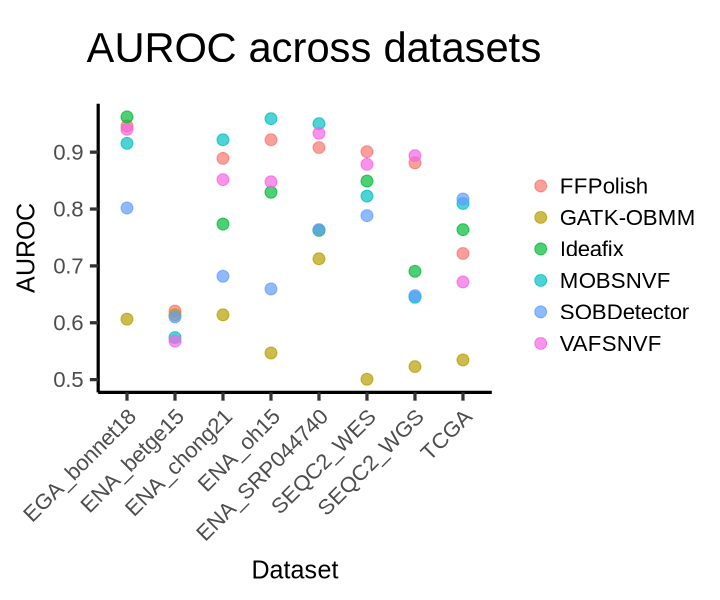

In [9]:
options(repr.plot.width = 6, repr.plot.height = 5)
all_dset_auroc <- plot_auc_dot(auc, x_col = "dataset", y_col = "auroc", fill_col = "model", y_label = "AUROC", title = "AUROC across datasets", legend_scale = 1, legend_position = "right", legend_row = 6)
qdraw(all_dset_auroc, "plots/all_dset_auroc.pdf", width=6, height=5)
all_dset_auroc

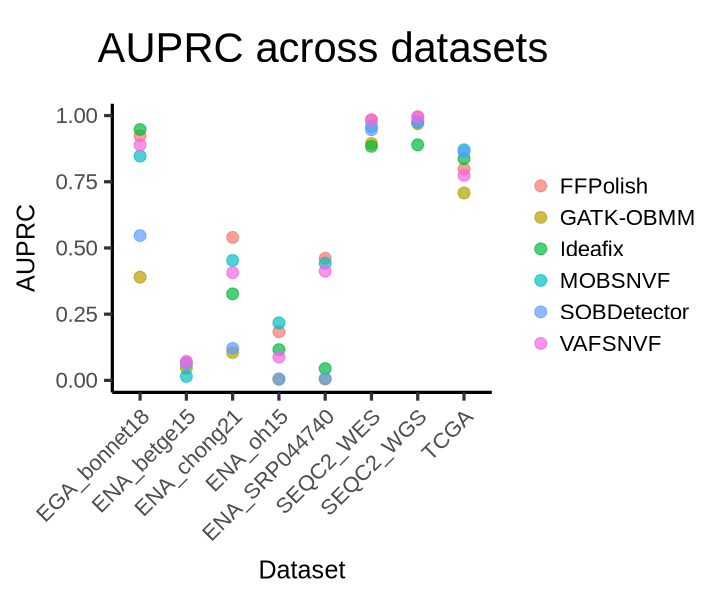

In [10]:
options(repr.plot.width = 6, repr.plot.height = 5) # set width to 10 inches, height to 6 inches
all_dset_auprc <- plot_auc_dot(auc, x_col = "dataset", y_col = "auprc", fill_col = "model", y_label = "AUPRC", title = "AUPRC across datasets", legend_scale = 1, legend_position = "right", legend_row = 6)
qdraw(all_dset_auprc, "plots/all_dset_auprc.pdf", width=6, height=5)
all_dset_auprc

## Model Specific Plots

### SOBDetector

In [11]:
## Prepare Data
sob_auc <- auc[auc$model == "SOBDetector", ]
sob_auc$dset_type <- if_else(sob_auc$dataset == "TCGA", "Used for\nTraining/Testing", "Not used for\nTraining/Testing")
sob_auc$dset_type <- factor(sob_auc$dset_type, levels = c("Used for\nTraining/Testing", "Not used for\nTraining/Testing"))

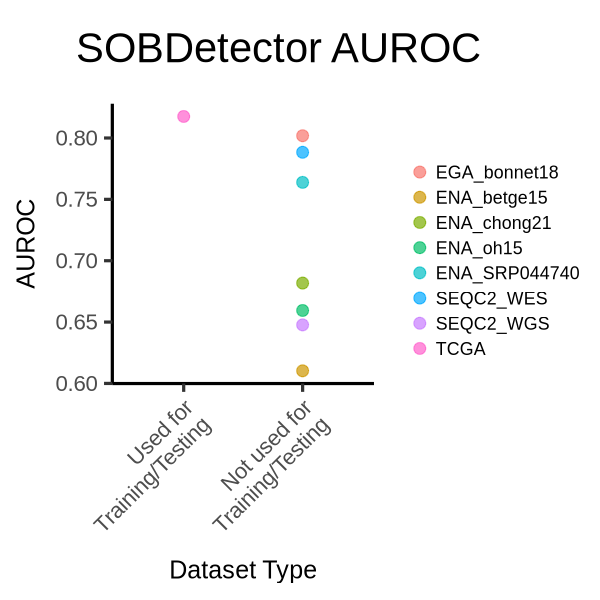

In [12]:
## AUROC
options(repr.plot.width = 5, repr.plot.height = 5) # set width to 10 inches, height to 6 inches
sob_auroc <- plot_auc_dot(
	sob_auc, x_col = "dset_type", y_col = "auroc", fill_col = "dataset", 
	x_label = "Dataset Type", y_label = "AUROC", title = "SOBDetector AUROC", 
	legend_scale = 0.8, legend_row = 8, legend_position = "right"
)
qdraw(sob_auroc, "plots/sobdetector_auroc.pdf", width = 5, height = 5)
sob_auroc

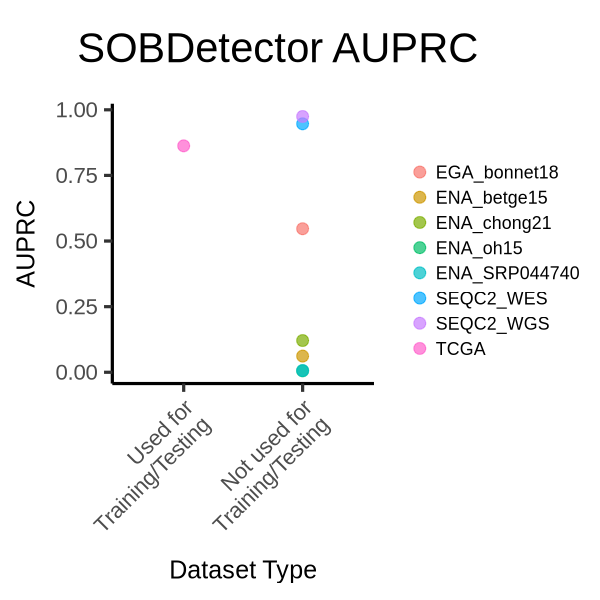

In [13]:
# AUPRC
options(repr.plot.width = 5, repr.plot.height = 5)
sob_auprc <- plot_auc_dot(
	sob_auc, x_col = "dset_type", y_col = "auprc", fill_col = "dataset", 
	x_label = "Dataset Type", y_label = "AUPRC", title = "SOBDetector AUPRC", 
	legend_scale = 0.8, legend_row = 8, legend_position = "right"
)
qdraw(sob_auprc, "plots/sobdetector_auprc.pdf", width = 5, height = 5)
sob_auprc

### Ideafix

In [14]:
## Prepare Data
ideafix_dsets <- c('ENA_chong21', 'EGA_bonnet18', 'ENA_SRP044740')
ideafix_auc <- auc[auc$model == "Ideafix", ]
ideafix_auc$dset_type <- if_else(ideafix_auc$dataset %in% ideafix_dsets, "Used for\nTraining/Testing", "Not used for\nTraining/Testing")
ideafix_auc$dset_type <- factor(ideafix_auc$dset_type, levels = c("Used for\nTraining/Testing", "Not used for\nTraining/Testing"))

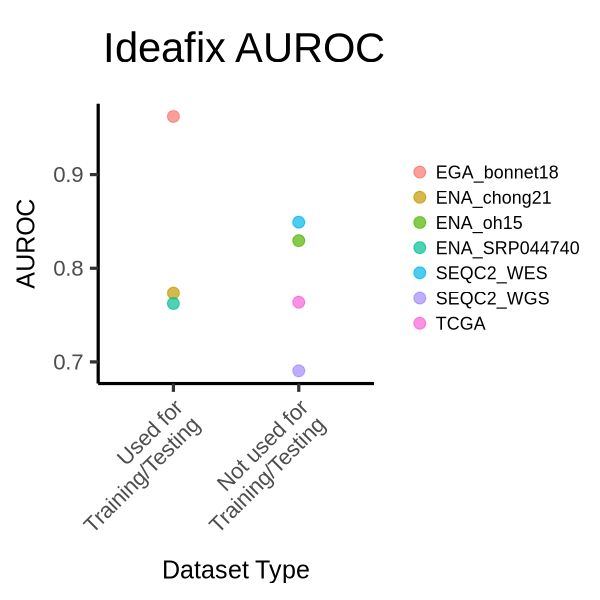

In [15]:
## AUROC
options(repr.plot.width = 5, repr.plot.height = 5)
ideafix_auroc <- plot_auc_dot(
	ideafix_auc, x_col = "dset_type", y_col = "auroc", fill_col = "dataset", 
	x_label = "Dataset Type", y_label = "AUROC", title = "Ideafix AUROC", 
	legend_scale = 0.8, legend_row = 8, legend_position = "right"
)
qdraw(ideafix_auroc, "plots/ideafix_auroc.pdf", width = 5, height = 5)
ideafix_auroc

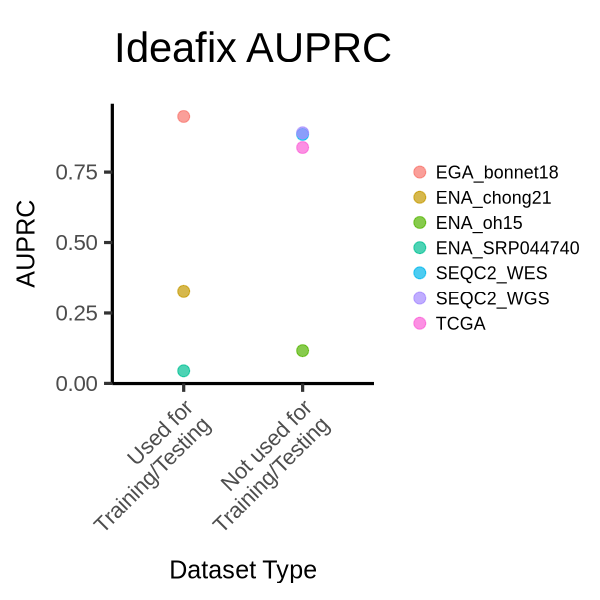

In [16]:
# AUPRC
options(repr.plot.width = 5, repr.plot.height = 5)
ideafix_auprc <- plot_auc_dot(
	ideafix_auc, x_col = "dset_type", y_col = "auprc", fill_col = "dataset", 
	x_label = "Dataset Type", y_label = "AUPRC", title = "Ideafix AUPRC", 
	legend_scale = 0.8, legend_row = 8, legend_position = "right"
)
qdraw(ideafix_auprc, "plots/ideafix_auprc.pdf", width = 5, height = 5)
ideafix_auprc